In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import datetime
import altair as alt
import plotly.plotly as py
import plotly.graph_objs as go
import squarify
import geopandas as gpd
import folium
from user_definition import *
from data_processing import *
import itertools

# San Francisco Bike Share Data Visualisation Project

## Introduction

This dataset is from the Ford Go Bike bike share service, which has bike stations installed across the Bay Area that users can hire for a period of time. It is freely accessible at https://s3.amazonaws.com/fordgobike-data/index.html, and is stored in the form of several .csv files corresponding to different months or years. I chose this particular dataset as I'm interested the analysis and modelling of transportation data, and this dataset allowed me to explore new ways of visualising geospatial data. I was hoping to use this data to explore interesting trends and events in San Francisco's bike sharing activity.

## Summary of Data

In [4]:
bike_df = pd.read_csv('data/fordgobike-tripdata.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.



In [9]:
bike_df['start_time'] = pd.to_datetime(bike_df['start_time'])
bike_df['end_time'] = pd.to_datetime(bike_df['end_time'])
bike_df['hour'] = bike_df.start_time.dt.hour
bike_df['minute'] = bike_df.start_time.dt.minute
bike_df['day'] = bike_df.start_time.dt.dayofweek
bike_df['dayoftravel'] = bike_df.start_time.dt.floor('d')
bike_df['month'] = bike_df.start_time.dt.month
bike_df['dayofyear'] = bike_df.start_time.dt.dayofyear
bike_df['dayofmonth'] = bike_df.start_time.dt.day
bike_df['year'] = bike_df.start_time.dt.year
bike_df['hourminuteoftravel'] = bike_df['start_time'].map(floor_time).dt.time

We can look first of all at the overall number of trips taken over time. We see that there is a strong seasonality present in the data as well as a trend of increasing numbers of trips being taken over time.

In [10]:
num_trips_over_time = bike_df.groupby('dayoftravel').count().iloc[:,[0]].reset_index()
num_trips_over_time.columns = ['dayoftravel', 'count']

In [11]:
sns.set_context('notebook')

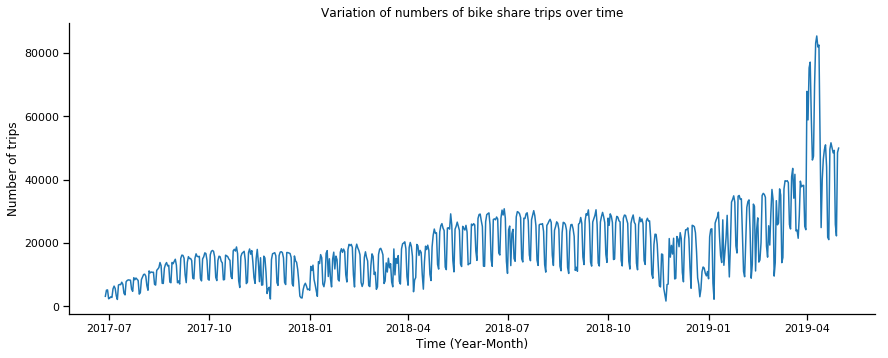

In [39]:
g = sns.relplot(x='dayoftravel', y='count', data=num_trips_over_time, kind='line', height=5, aspect=2.5)
plt.xlabel('Time (Year-Month)')
plt.ylabel('Number of trips')
plt.title('Variation of numbers of bike share trips over time')
plt.show()

In [23]:
idx = (bike_df.year == 2018)
num_trips_over_time_usertype = bike_df[idx].groupby(['dayoftravel', 'user_type']).count().iloc[:,[0]].reset_index()
num_trips_over_time_usertype.columns = ['Date', 'User Type', 'Number of trips']

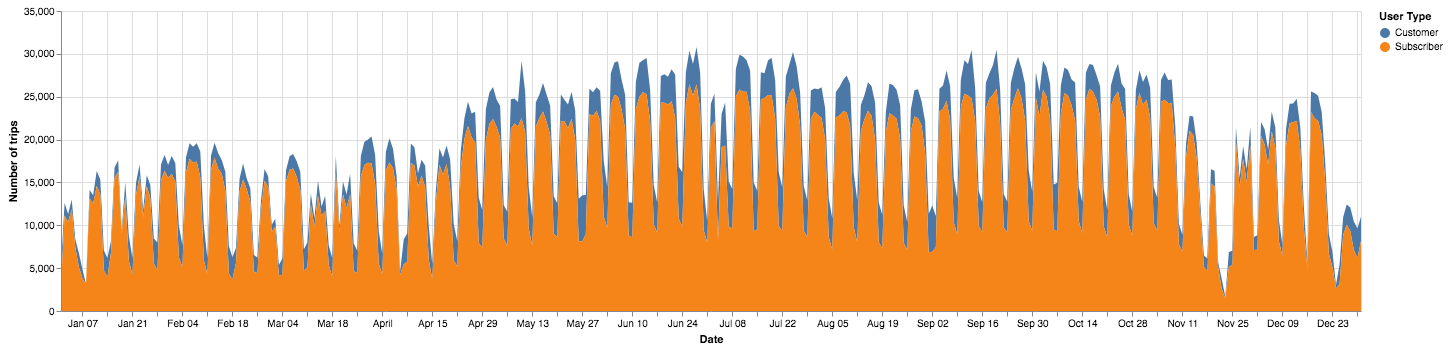

In [24]:
alt.Chart(num_trips_over_time_usertype, width=1300, height=300).mark_area().encode(
    x="Date:T",
    y="Number of trips:Q",
#     y=alt.Y('count:Q', stack='center', axis=None),
    color="User Type:N"
)

In [28]:
count_by_month = bike_df[bike_df['year'] == 2018].groupby('month').size().reset_index()
month_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
             7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
count_by_month.columns = ['month', 'count']
count_by_month.month = count_by_month.month.map(month_map)
norm = matplotlib.colors.Normalize(vmin=min(count_by_month['count']), vmax=max(count_by_month['count']))
colors = [matplotlib.cm.Reds(norm(value)) for value in count_by_month['count']]

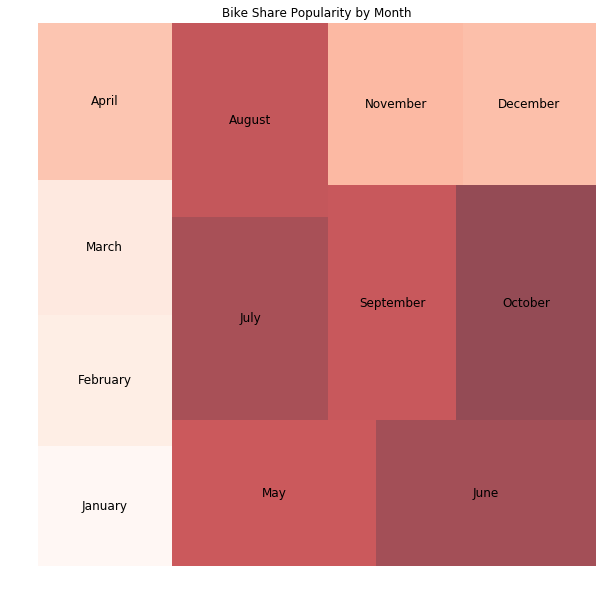

In [31]:
fig = plt.figure(figsize=(10,10))
squarify.plot(sizes=count_by_month['count'], label=count_by_month['month'], alpha=0.7, color=colors)
plt.axis('off')
plt.title('Bike Share Popularity by Month')
plt.show()

The dataset also contains information on the duration of trips, we can visualise this distribution using a histogram. We see that the distribution for subscribers is right skewed with a mode of around 10 minutes. The distribution for non-subscribers is also right skewed with a wider variance, with a higher mean. This can be interpreted as subscribers being mostly commuters who might take shorter journeys on average. 

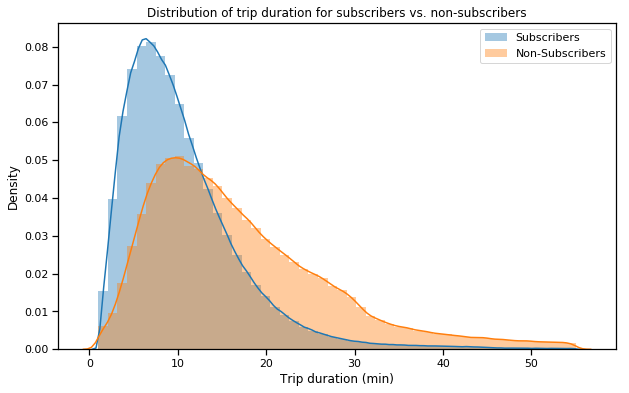

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
idx = (bike_df.duration_sec < bike_df.duration_sec.quantile(0.98)) & (bike_df.user_type == 'Subscriber')
sns.distplot(bike_df[idx].duration_sec/60.0, ax=ax, label='Subscribers')
idx = (bike_df.duration_sec < bike_df.duration_sec.quantile(0.98)) & (bike_df.user_type == 'Customer')
sns.distplot(bike_df[idx].duration_sec/60.0, ax=ax, label='Non-Subscribers')
ax.set_xlabel('Trip duration (min)')
ax.set_ylabel('Density')
plt.title('Distribution of trip duration for subscribers vs. non-subscribers')
plt.legend()
plt.show()

It is interesting to look at the variation of trip frequency over time of day. The following plot looks at the distribution of the number of trips over time of day, represented by boxplots for each hour of the day. It can be seen that there are two peaks in the number of trips taken at 8AM and 5PM, corresponding to the most frequent times for commuters. We also see that these times have the largest variability which could be due to weekend vs weekday trips.

In [36]:
count_by_hour_day = bike_df.groupby(['hour', 'dayoftravel']).count().iloc[:,[0]].reset_index()
count_by_hour_day.columns = ['hour', 'day', 'count']

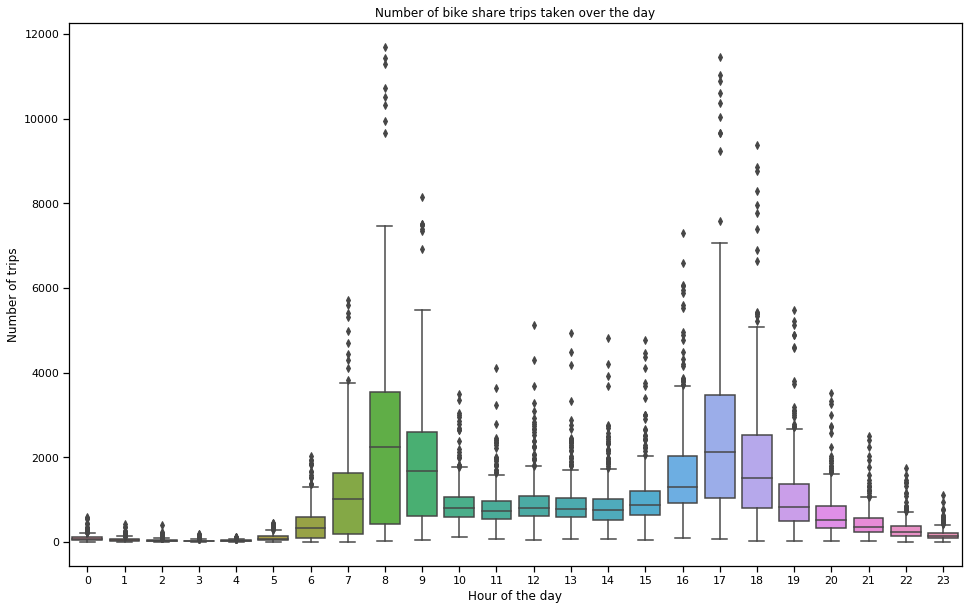

In [37]:
fig, ax = plt.subplots(figsize=(16,10))
sns.boxplot(x='hour', y='count', data=count_by_hour_day, ax=ax)
ax.set_ylabel('Number of trips')
ax.set_xlabel('Hour of the day')
plt.title('Number of bike share trips taken over the day')
plt.show()

Breaking down the trips taken into weekdays and weekends, we also see a large amount of variability in the number of trips taken on the weekend compared to weekday. More trips are taken at nearly any time during the day in the week, apart from around midday where there are more trips taken on the weekend. The two peaks around 8 am and 5 pm are again clearly seen here.

In [41]:
count_by_dow = bike_df.groupby(['day', 'hourminuteoftravel']).count().iloc[:,[0]].reset_index()
count_by_dow.columns = ['day', 'hourminuteoftravel', 'count']
dow_map = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
count_by_dow['day'] = count_by_dow['day'].map(dow_map)

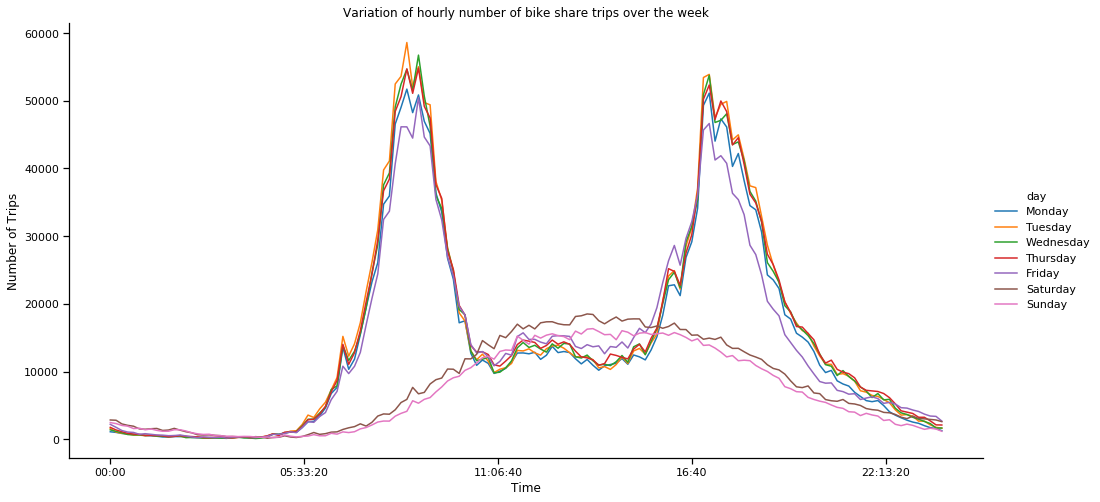

In [42]:
sns.relplot(x='hourminuteoftravel', y='count', data=count_by_dow, hue='day', kind='line', height=7, aspect=2)
plt.xlabel('Time')
plt.ylabel('Number of Trips')
plt.title('Variation of hourly number of bike share trips over the week')
plt.show()

Another way of looking at this data set is spatially, to uncover geographical trends in the transportation habits of bike users in San Francisco. In the following plot the most popular stations over time are examined:

In [33]:
most_popular_stations = bike_df.groupby('start_station_name').count().iloc[:,[0]].reset_index()
most_popular_stations.columns = ['start_station_name', 'count']
most_popular_stations.sort_values('count', ascending=False, inplace=True)

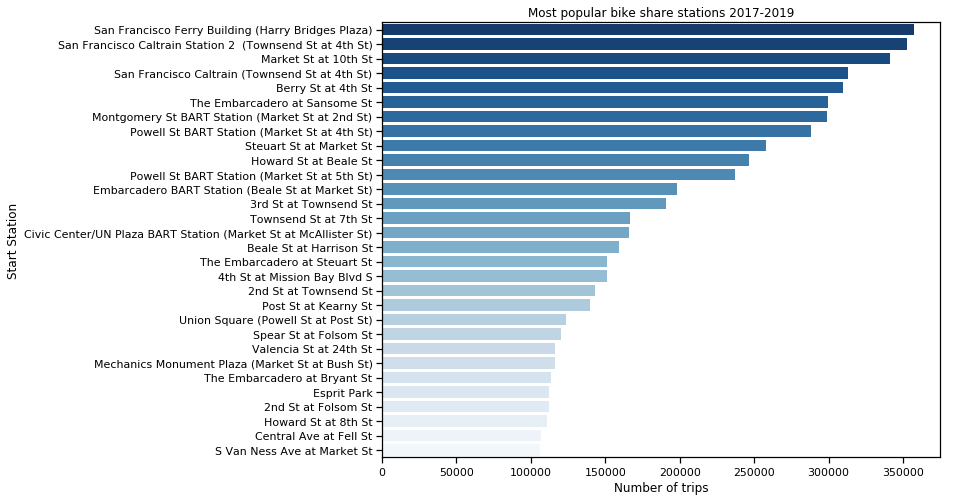

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(y='start_station_name', x='count', data=most_popular_stations.iloc[:30], ax=ax, palette='Blues_r')
ax.set_xlabel('Number of trips')
ax.set_ylabel('Start Station')
plt.title('Most popular bike share stations 2017-2019')
plt.show()

The next plot examines the stations' popularity on a geographical map:

In [257]:
station_count = bike_df.groupby('start_station_name').count().iloc[:,[0]].reset_index()
station_count.columns = ['start_station_name', 'count']
station_count = station_count.merge(bike_df[['start_station_name', 
                                             'start_station_latitude', 
                                             'start_station_longitude']], on='start_station_name').drop_duplicates()
station_count.columns = ['start_station_name', 'count', 'lat', 'lon']
station_count['lat'] = station_count['lat'].round(4)
station_count['lon'] = station_count['lon'].round(4)
station_count = station_count.drop_duplicates().reset_index()

In [271]:
station_count['count'].mean()/1000

43.49889956331878

In [274]:
station_count['text'] = station_count['start_station_name'] + '<br>Number of trips: ' + (station_count['count']).astype(str)

It would be interesting to see how the distribution of trip times across the day shifts throughout the year. To do this we can use a heatmap where the x axis corresponds to the time of the day, the y axis corresponds to the time of the year and the colour is the average number of trips made at this time.

In [338]:
avg_trips_timeofday_dayofyear = bike_df.groupby(['hourminuteoftravel', 'dayoftravel']).count().iloc[:,[0]].reset_index()
avg_trips_timeofday_dayofyear.columns = ['hourminuteoftravel', 'dayoftravel', 'count']
avg_trips_timeofday_dayofyear['dayofyear'] = avg_trips_timeofday_dayofyear['dayoftravel'].dt.dayofyear
avg_trips_timeofday_dayofyear = avg_trips_timeofday_dayofyear.groupby(['hourminuteoftravel', 'dayofyear'])['count'].mean().reset_index()
# avg_trips_timeofday_dayofyear['dayofyear'] = pd.to_datetime(avg_trips_timeofday_dayofyear['dayofyear'], format='%j').dt.strftime('%d %B')
avg_trips_timeofday_dayofyear = avg_trips_timeofday_dayofyear.pivot(index='hourminuteoftravel', columns='dayofyear', values='count')
avg_trips_timeofday_dayofyear.fillna(value=0, inplace=True)

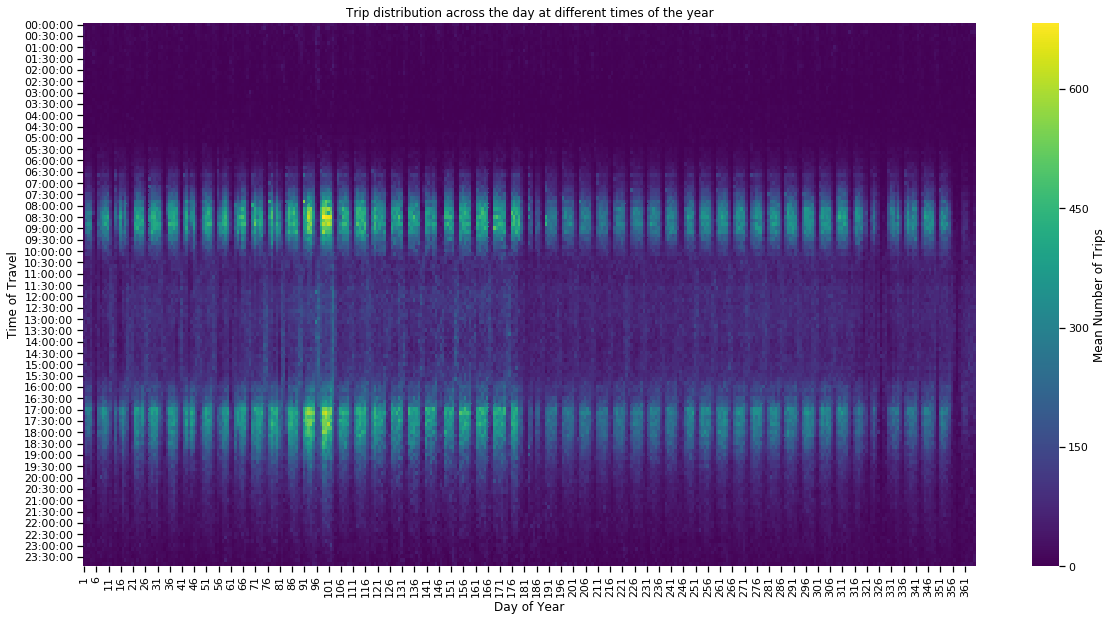

In [339]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(data=avg_trips_timeofday_dayofyear, ax=ax, cmap='viridis', cbar_kws={'label': 'Mean Number of Trips'})
ax.set_xlabel('Day of Year')
ax.set_ylabel('Time of Travel')
ax.set_title('Trip distribution across the day at different times of the year')
plt.show()

In [385]:
geocoder = geopy.geocoders.MapBox(api_key=mapbox_access_token)
results = geocoder.reverse((bike_df['start_station_latitude'][0], bike_df['start_station_longitude'][0]))

In [401]:
fp = "sf_zipcodes/geo_export_27202422-c66f-4c60-98ba-0405c2ef5022.shp"
map_df = gpd.read_file(fp)

In [445]:
geocoder = geopy.geocoders.MapBox(api_key=mapbox_access_token)

In [477]:
def reverse_geocode(row, geocoder):
    results = geocoder.reverse((row['lat'], row['lon']))
    try:
        zipcode = results.address.split(',')[2].split(' ')[2]
        int(zipcode[0])
    except ValueError:
        zipcode = results.address.split(',')[3].split(' ')[2]
    return zipcode

In [478]:
station_zip_codes = []
for i, row in station_count.iterrows():
    station_zip_codes.append((row['start_station_name'], reverse_geocode(row, geocoder)))

In [480]:
station_zip_codes = [address[1] for address in station_zip_codes]

In [483]:
station_count['zip'] = station_zip_codes

In [508]:
zip_area_count = station_count[['zip', 'count']].groupby('zip').sum().reset_index()

In [564]:
zip_area_count = map_df['zip'].reset_index().merge(zip_area_count, how='left').fillna(0)[['zip', 'count']]

In [545]:
sf_geo = map_df.to_json()

In [574]:
m = folium.Map(location=[bike_df.start_station_latitude.mean(), 
                         bike_df.start_station_longitude.mean()], zoom_start=12, tiles='cartodbpositron')
m.choropleth(
    geo_data=sf_geo,
    name='choropleth',
    data=zip_area_count,
    columns=['zip', 'count'],
    key_on='properties.zip',
    fill_color='YlGn',
    fill_opacity=0.6,
    line_opacity=0.2,
    legend_name='Number of Bike Rentals'
)
folium.LayerControl().add_to(m)
m

In [42]:
idx = (bike_df['year'] == 2018) & (bike_df['month'] == 1) & (bike_df['dayofmonth'] == 8)
bike_df['start_station_latitude'] = bike_df['start_station_latitude'].round(4)
bike_df['start_station_longitude'] = bike_df['start_station_longitude'].round(4)
station_count_rainy = bike_df[idx].groupby(['start_station_name', 'start_station_latitude', 'start_station_longitude']).count().iloc[:,[0]].reset_index()
station_count_rainy.columns = ['start_station_name', 'lat', 'lon', 'count']
station_count_rainy['text'] = station_count_rainy['start_station_name'] + '<br>Number of trips: ' + (station_count_rainy['count']).astype(str)

In [48]:
data = [go.Scattermapbox(
            lat=station_count_rainy['lat'],
            lon=station_count_rainy['lon'],
            mode='markers',
            marker=go.Marker(size=station_count_rainy['count']/10),
            text=station_count_rainy['text'],
            hoverinfo='text'
)]

layout = go.Layout(
            title='Bike usage during a rainy day',
            autosize=True,
            hovermode='closest',
            showlegend=False,
            height=700,
            mapbox={'accesstoken': mapbox_access_token,
                    'bearing': 0,
                    'center': {'lat': station_count_rainy['lat'].mean(),
                               'lon': station_count_rainy['lon'].mean()},
                    'pitch': 0, 
                    'zoom': 12,
                    'style': 'dark'}
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='station_count')

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [76]:
idx = (bike_df['year'] == 2018) & (bike_df['month'] == 5) & (bike_df['dayofmonth'] == 18)
bike_df['start_station_latitude'] = bike_df['start_station_latitude'].round(4)
bike_df['start_station_longitude'] = bike_df['start_station_longitude'].round(4)
station_count_btw_day = bike_df[idx].groupby(['start_station_name', 'start_station_latitude', 'start_station_longitude']).count().iloc[:,[0]].reset_index()
station_count_btw_day.columns = ['start_station_name', 'lat', 'lon', 'count']
station_count_btw_day['text'] = station_count_btw_day['start_station_name'] + '<br>Number of trips: ' + (station_count_btw_day['count']).astype(str)

In [49]:
data = [go.Scattermapbox(
            lat=station_count_btw_day['lat'],
            lon=station_count_btw_day['lon'],
            mode='markers',
            marker=go.Marker(size=station_count_btw_day['count']/10),
            text=station_count_btw_day['text'],
            hoverinfo='text'
)]

layout = go.Layout(
            title='Bike usage during Bike to Work day 2018',
            autosize=True,
            hovermode='closest',
            showlegend=False,
            height=700,
            mapbox={'accesstoken': mapbox_access_token,
                    'bearing': 0,
                    'center': {'lat': station_count_btw_day['lat'].mean(),
                               'lon': station_count_btw_day['lon'].mean()},
                    'pitch': 0, 
                    'zoom': 12,
                    'style': 'dark'}
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='station_count')

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [44]:
polylines_df = pd.read_csv('paths_polylines.csv')

In [48]:
polylines_df.drop('Unnamed: 0', axis=1, inplace=True)

In [49]:
polylines_df_reversed = pd.DataFrame()
polylines_df_reversed['start_station'] = polylines_df['end_station']
polylines_df_reversed['end_station'] = polylines_df['start_station']
polylines_df_reversed['polyline'] = polylines_df['polyline']

In [57]:
polylines_df_full = pd.concat([polylines_df[['start_station', 'end_station', 'polyline']], polylines_df_reversed], axis=0)
polylines_df_full.columns = ['start_station_name', 'end_station_name', 'polyline']

In [69]:
popular_routes = bike_df.groupby(['start_station_name', 'end_station_name']).count().iloc[:,[0]].reset_index()
popular_routes.columns = ['start_station_name', 'end_station_name', 'count']
popular_routes.sort_values('count', ascending=False, inplace=True)
popular_routes = popular_routes.iloc[:500, :]

In [70]:
popular_routes_paths = popular_routes.merge(polylines_df_full, on=['start_station_name', 'end_station_name'])

In [71]:
popular_routes_paths.head()

,start_station_name,end_station_name,count,polyline
0,San Francisco Ferry Building (Harry Bridges Pl...,The Embarcadero at Sansome St,66380,u|teF~a`jVoE`EsHtGyBhB{ClCmKbJqOxMkArAaCnDVXFHT]
1,The Embarcadero at Sansome St,Steuart St at Market St,41265,mtteFrc`jV{@jAADAD?BE?AAC?q@_AAA_@h@II?AC@_@Xq...
2,Berry St at 4th St,San Francisco Ferry Building (Harry Bridges Pl...,40695,mbqeFp|_jViGsI_@i@]a@KPSX{@hA_EwFcDgEkBgCm@i@e...
3,The Embarcadero at Sansome St,San Francisco Ferry Building (Harry Bridges Pl...,33421,u|teF~a`jVoE`EsHtGyBhB{ClCmKbJqOxMkArAaCnDVXFHT]
4,San Francisco Ferry Building (Harry Bridges Pl...,Berry St at 4th St,29066,mbqeFp|_jViGsI_@i@]a@KPSX{@hA_EwFcDgEkBgCm@i@e...


In [72]:
path_coords = []
for i, row in popular_routes_paths.iterrows():
    path_lats, path_lons = get_path(row['polyline'])
    path_coords.append((path_lats, path_lons))

In [77]:
data = [
    go.Scattermapbox(
        lat=coords[0],
        lon=coords[1],
        mode='lines',
#         fillcolor='red'
#         width=1,
#         color='red'
        opacity=0.7,
        line = go.Line(
            width = 1,
            color = 'white',
        )
    )
 for coords in path_coords]

layout = go.Layout(
            title='Top 500 Bike Routes in San Francisco',
            autosize=True,
            hovermode='closest',
            showlegend=False,
            height=700,
            mapbox={'accesstoken': mapbox_access_token,
                    'bearing': 0,
                    'center': {'lat': station_count_btw_day['lat'].mean(),
                               'lon': station_count_btw_day['lon'].mean()},
                    'pitch': 0, 
                    'zoom': 12,
                    'style': 'dark'}
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='station_count')

/anaconda3/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

